# Hierarchical Star - Spectroscopic Observables

This notebook shows how you can use the `MultieStarModel` to infer stellar parameters with spectroscopic observables effective temperature, surface gravity, and metallicity (`Teff`, `log_g`, `M_H`).

Firstly, import packages.

In [3]:
import numpy as np
import numpyro
import arviz as az
import matplotlib.pyplot as plt

from pprint import pprint
from corner import corner
from jax import random, vmap
from numpyro import handlers
from numpyro.infer import MCMC, NUTS, Predictive, init_to_median, init_to_value
from numpyro.infer.reparam import LocScaleReparam
from time import time
# numpyro.set_host_device_count(10)
# numpyro.enable_x64()
numpyro.set_host_device_count(2)

Then, import the `HierarchicalStarModel` from `celestify`.

In [4]:
from celestify.numpyro_models import HierarchicalStarModel

## Truths

Let's synthesis some true parameters for our star from the `SingleStarModel` prior.

In [5]:
# hyperparam_names = ["mu_Y", "mu_a", "sigma_Y", "sigma_a"]
hyperparam_names = ["dY_dZ", "sigma_Y", "da_dM", "sigma_a"]
# hyperparam_names = ["dY_dZ", "sigma_Y", "mu_a", "sigma_a"]

In [7]:
rng = random.PRNGKey(0)  # create random key to use throughout notebook
num_stars = 500

rng, key = random.split(rng)
true_model = HierarchicalStarModel(num_stars)
truths = {
    # "mu_Y": 0.27,
    "dY_dZ": 1.5,
    "sigma_Y": 0.005,
    # "mu_a": 2.0,
    "da_dM": -0.3,
    "sigma_a": 0.05,
}
# This samples from the true model given some random key
true_trace = handlers.trace(
    handlers.seed(handlers.substitute(true_model, truths), key)
).get_trace()
truths.update({key: param["value"] for key, param in true_trace.items()})
pprint(truths)

{'M_H': Array([-1.05286881e-01, -6.91014409e-01, -4.53328192e-01,  2.62481749e-01,
        1.80800840e-01, -3.25413167e-01, -6.38977468e-01, -1.18243076e-01,
       -7.88509905e-01, -5.54234505e-01,  3.10507387e-01,  3.01122852e-02,
        1.99867278e-01,  3.47855777e-01, -6.58934042e-02,  3.06868136e-01,
        3.30331355e-01,  2.13050798e-01, -6.02062702e-01,  1.81904793e-01,
       -3.67568284e-01,  2.60093898e-01, -2.38565266e-01, -1.45483270e-01,
        4.79368120e-02, -4.33014601e-01, -7.06296980e-01, -8.09156179e-01,
       -1.74164012e-01,  2.87069142e-01, -4.74942438e-02,  1.32746086e-01,
        1.53391749e-01, -6.65097594e-01, -4.87561822e-01,  1.15794558e-02,
       -8.74864578e-01, -1.45823672e-01, -3.07406962e-01, -5.87411404e-01,
        4.11625691e-02,  2.87297666e-01, -1.32893935e-01,  2.12986425e-01,
       -6.80475771e-01,  4.07892205e-02, -7.16708601e-01,  1.36724651e-01,
        2.90878803e-01, -1.89072073e-01, -8.61733258e-02, -1.48171946e-01,
       -6.2319880

## Model

Now, let's create our star model. We need to provide some model constants. These are typically shape parameters for prior distributions. You can see the full `dict` of constants in the `model.const` attribute.

In [8]:
rng, key = random.split(rng)

sigma_mh = 0.1
mu_mh = truths["M_H"] + sigma_mh * random.normal(key, shape=truths["M_H"].shape)  # add noise to metallicity prior

# Create dictionary of model constants
const = {
    "M_H": dict(loc=mu_mh, scale=sigma_mh),
    "Teff": dict(scale=100.),
    "log_g": dict(scale=0.1),
}

# Create model
model = HierarchicalStarModel(num_stars, const=const)

pprint(model.const)  # check all constants

{'M_H': {'loc': Array([-0.1369285 , -0.5508615 , -0.5214349 ,  0.3960588 ,  0.1583047 ,
       -0.33015078, -0.58989877, -0.07315555, -0.9072484 , -0.3839663 ,
        0.21751747, -0.06911482,  0.11655555,  0.37764567,  0.02392326,
        0.39503396,  0.35976785,  0.14301261, -0.5636119 ,  0.28652027,
       -0.36856863,  0.25319803, -0.2574497 , -0.23401412, -0.12061581,
       -0.39161152, -0.5299091 , -0.6963143 , -0.08842807,  0.45443538,
       -0.02609204,  0.13377194,  0.2295365 , -0.46623337, -0.3986802 ,
        0.04818311, -0.65021265, -0.10175301, -0.44205087, -0.58754325,
       -0.02128888,  0.12504333, -0.21338676,  0.23479399, -0.65256524,
        0.27838308, -0.6660113 ,  0.1481599 ,  0.2045303 , -0.15895864,
       -0.04271636, -0.19722012, -0.68468285,  0.13559225, -0.13999465,
       -0.08934416, -0.50744456, -0.17291024,  0.04648824, -0.44926113,
       -0.07651778, -0.21214356,  0.409968  , -0.64617443, -0.4032836 ,
        0.2335469 , -0.13291669, -0.11539087, -0

## Prior Predictive

Sample from the model prior.

In [9]:
rng, key = random.split(rng)
prior_predictive = Predictive(model, num_samples=1000)
prior_samples = prior_predictive(key)

Let's put the prior samples in an `arviz.InferenceData` class. This makes it easier to plot and save.

In [40]:
coords = {"star": np.arange(num_stars)}
dims = {key: ["star"] for key, value in prior_samples.items() if value.ndim > 1}
data = az.from_numpyro(prior=prior_samples, coords=coords, dims=dims)
data

Inference data with groups:
	> prior

We can plot the prior and overlay the true values with the `corner` package.

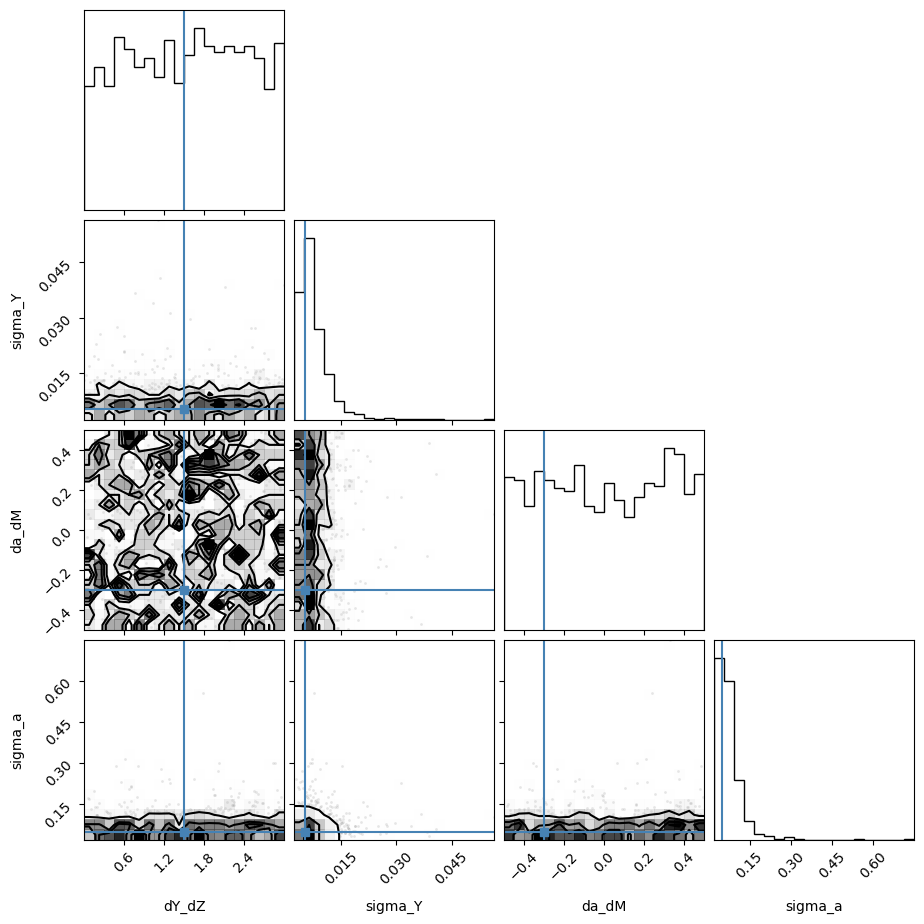

In [11]:
fig = corner(data, group="prior", var_names=hyperparam_names, truths=truths)

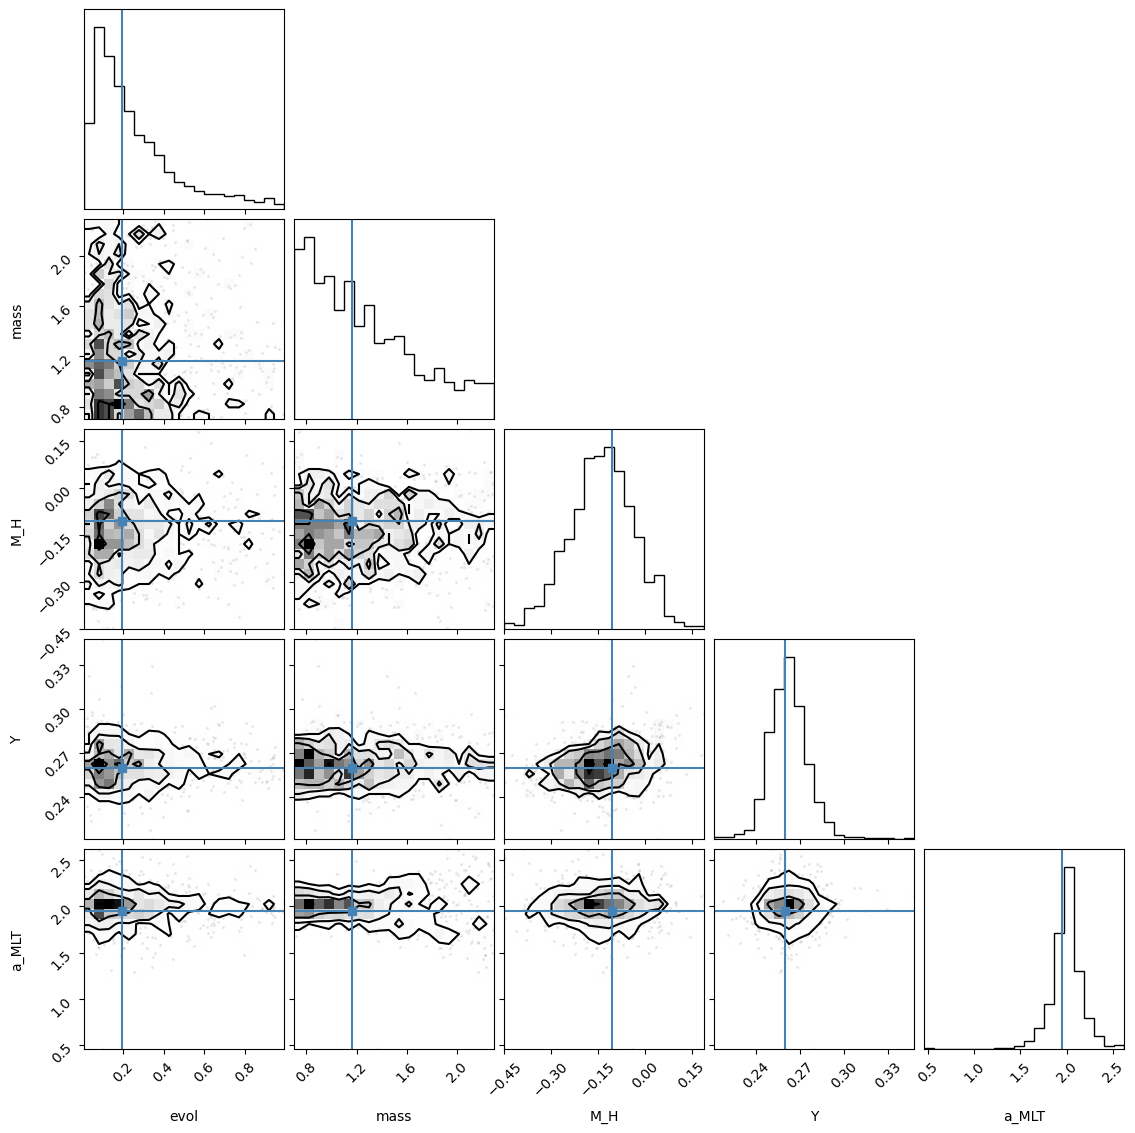

In [12]:
star = 0
var_names = ["evol", "mass", "M_H", "Y", "a_MLT"]
coords_ = {"star": star}
truths_ = {key: truths[key][star] for key in var_names}
fig = corner(data, group="prior", var_names=var_names, truths=truths_, coords=coords_)

Let's also look at some determinisitc parameters in the model.

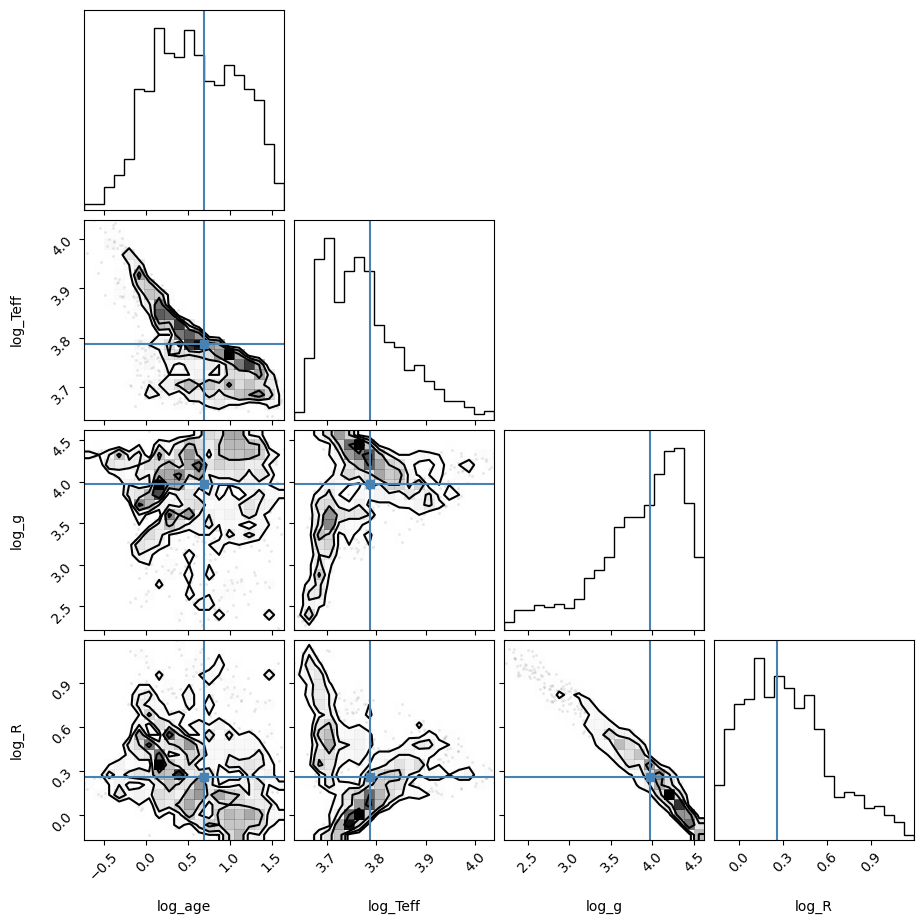

In [13]:
star = 0
var_names = ["log_age", "log_Teff", "log_g", "log_R"]
coords_ = {"star": star}
truths_ = {key: truths[key][star] for key in var_names}
fig = corner(data, group="prior", var_names=var_names, truths=truths_, coords=coords_)

## Observation

Now we synthesize observable parameters for the model.

In [14]:
rng, *keys = random.split(rng, 3)
obs = {
    "Teff": truths["Teff"] + const["Teff"]["scale"] * random.normal(keys[0], shape=truths["Teff"].shape),
    "log_g": truths["log_g"] + const["log_g"]["scale"] * random.normal(keys[1], shape=truths["log_g"].shape),
}
pprint(obs)

{'Teff': Array([ 6237.62  ,  5811.681 ,  5638.2144,  7495.373 ,  7158.661 ,
        4672.9673, 12109.992 ,  6945.9175,  8920.016 ,  7205.631 ,
        6245.0835,  5015.6934,  4656.188 ,  5656.9946,  5974.538 ,
        5562.1353,  6459.3804,  7370.602 ,  7566.7856,  5515.2065,
        5090.0874,  4979.7285,  6246.0083,  8831.835 ,  8644.878 ,
        6205.3154,  7251.427 ,  5324.4185,  4782.9966,  5071.782 ,
        6290.9116,  4561.672 ,  4647.5317, 10677.429 ,  9455.061 ,
        5546.7266,  9855.843 ,  4835.914 ,  7204.231 ,  6803.1006,
        4847.6494,  4605.263 ,  4925.302 ,  5897.4214, 10008.41  ,
        6412.399 ,  7842.7295,  7947.238 ,  4684.457 ,  7265.4536,
        5336.5327, 10056.984 ,  5990.3506,  6182.8003,  6886.8335,
        5043.584 ,  4917.316 ,  9785.716 ,  5551.762 ,  8435.597 ,
        6773.845 ,  5663.6533,  5121.0845,  7872.401 ,  8647.25  ,
        4830.033 ,  6486.6294,  4803.49  ,  8803.535 ,  5564.8613,
        6126.7036,  9201.578 ,  6198.816 ,  4933.437 

## Sampling

Let's use the No U-Turn Sampler (NUTS) as our Markov Chain Monte Carlo (MCMC) sampling algorithm.

In [37]:
# sampler = NUTS(model, target_accept_prob=0.8, dense_mass=[("dY_dZ", "da_dM", "sigma_Y", "sigma_a")], init_strategy=init_to_median)
sampler = NUTS(model, target_accept_prob=0.8, init_strategy=init_to_median)
mcmc = MCMC(sampler, num_warmup=2000, num_samples=2000, num_chains=2)

Let's run the MCMC and print a summary of results.

In [38]:
rng, key = random.split(rng)
start = time()
mcmc.run(key, obs=obs)
elapsed_time = time() - start
mcmc.print_summary()

/home/alex/miniconda3/envs/celestify-cuda/lib/python3.10/site-packages/jax/_src/linear_util.py:191: UserWarning: We will disable progress bar because it does not work yet on multi-GPUs platforms.
  ans = self.f(*args, **dict(self.params, **kwargs))



                       mean       std    median      5.0%     95.0%     n_eff     r_hat
           M_H[0]     -0.13      0.10     -0.13     -0.30      0.04    102.26      1.02
           M_H[1]     -0.55      0.10     -0.55     -0.70     -0.38    344.84      1.00
           M_H[2]     -0.51      0.10     -0.50     -0.66     -0.33    206.03      1.01
           M_H[3]      0.32      0.06      0.33      0.23      0.40    341.17      1.01
           M_H[4]      0.15      0.09      0.14     -0.01      0.29    228.71      1.01
           M_H[5]     -0.29      0.09     -0.29     -0.44     -0.13    351.16      1.01
           M_H[6]     -0.66      0.08     -0.66     -0.79     -0.53    148.96      1.01
           M_H[7]     -0.07      0.09     -0.07     -0.22      0.09    144.07      1.03
           M_H[8]     -0.80      0.07     -0.81     -0.90     -0.71    159.38      1.02
           M_H[9]     -0.34      0.11     -0.34     -0.52     -0.15     67.64      1.04
          M_H[10]      0.24    

Looks pretty good. We want `r_hat` to be close to 1.0 (e.g. less than 1.1). We also want the number of divergances to be very small.

**Note:** The `MultiStarModel` takes longer than running `SingleStarModel` sequentially, but includes population-level priors. It's worth looking at other ways to do this faster.

Let's update our `InferenceData`.

In [41]:
data += az.from_numpyro(mcmc, coords=coords, dims=dims)
data

Inference data with groups:
	> posterior
	> log_likelihood
	> sample_stats
	> prior
	> observed_data

With `arviz`, we can create a summary of the data.

In [42]:
summary = az.summary(data, fmt="xarray")
summary

<xarray.Dataset>
Dimensions:       (star: 500, metric: 9)
Coordinates:
  * star          (star) int64 0 1 2 3 4 5 6 7 ... 493 494 495 496 497 498 499
  * metric        (metric) <U9 'mean' 'sd' 'hdi_3%' ... 'ess_tail' 'r_hat'
Data variables: (12/22)
    M_H           (metric, star) float64 -0.1293 -0.5458 -0.5076 ... 1.009 1.011
    R             (metric, star) float64 1.836 0.9183 2.275 ... 1.009 1.001
    Teff          (metric, star) float64 6.238e+03 5.833e+03 ... 1.022 1.001
    Y             (metric, star) float64 0.2619 0.2522 0.2528 ... 1.013 1.01
    Y_decentered  (metric, star) float64 -0.001694 -0.06389 ... 1.011 1.001
    a_MLT         (metric, star) float64 1.966 2.024 2.001 ... 1.243 1.042 1.018
    ...            ...
    log_evol      (metric, star) float64 -0.7526 -0.8861 -0.513 ... 1.008 1.007
    log_g         (metric, star) float64 3.995 4.414 3.748 ... 1.008 1.003 1.001
    log_mass      (metric, star) float64 0.07478 -0.1026 ... 1.033 1.002
    mass          (metric, star) float64 1.192 0.791 1.017 ... 1.002 1.033 1.002
    sigma_Y       (metric) float64 0.006892 0.003136 0.002401 ... 107.9 1.056
    sigma_a       (metric) float64 0.0679 0.02739 0.02329 ... 83.41 206.8 1.012

In [43]:
elapsed_time

1647.2426958084106

In [44]:
efficiency = summary.sel(metric="ess_bulk") / elapsed_time

In [45]:
efficiency

<xarray.Dataset>
Dimensions:       (star: 500)
Coordinates:
  * star          (star) int64 0 1 2 3 4 5 6 7 ... 493 494 495 496 497 498 499
    metric        <U9 'ess_bulk'
Data variables: (12/22)
    M_H           (star) float64 0.09128 0.2079 0.1247 ... 0.1171 0.1806 0.1362
    R             (star) float64 0.3123 0.2727 0.162 ... 0.1311 0.2886 0.2623
    Teff          (star) float64 0.2758 1.049 0.6528 ... 2.563 0.2886 1.376
    Y             (star) float64 0.1663 0.2232 0.2273 ... 0.136 0.0999 0.2196
    Y_decentered  (star) float64 0.2016 0.214 0.1878 ... 0.278 0.2445 0.2486
    a_MLT         (star) float64 0.2042 0.1688 0.233 ... 0.004113 0.04868 0.1458
    ...            ...
    log_evol      (star) float64 0.08566 0.1669 0.1281 ... 0.02811 0.2257 0.1602
    log_g         (star) float64 0.2994 0.1835 0.1921 ... 0.1086 0.3841 0.2859
    log_mass      (star) float64 0.1021 0.2432 0.127 ... 0.1311 0.08292 0.1934
    mass          (star) float64 0.1021 0.2432 0.127 ... 0.1311 0.08292 0.1934
    sigma_Y       float64 0.02391
    sigma_a       float64 0.05064

In [46]:
values = []
for value in efficiency.values():
    values.append(np.atleast_1d(value))

eff = np.concatenate(values)

Text(0, 0.5, 'Count')

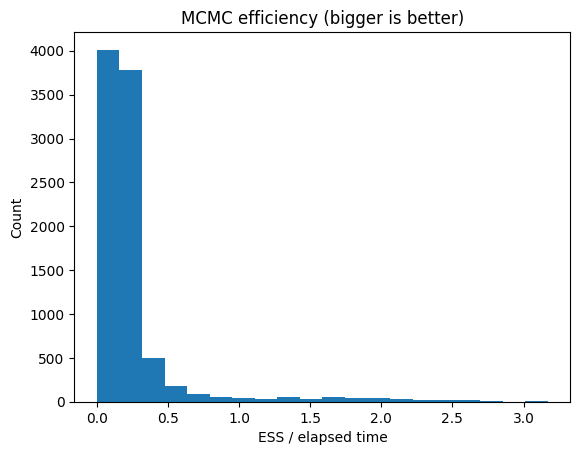

In [47]:
fig, ax = plt.subplots()

ax.hist(eff, bins=20)
ax.set_title("MCMC efficiency (bigger is better)")
ax.set_xlabel("ESS / elapsed time")
ax.set_ylabel("Count")

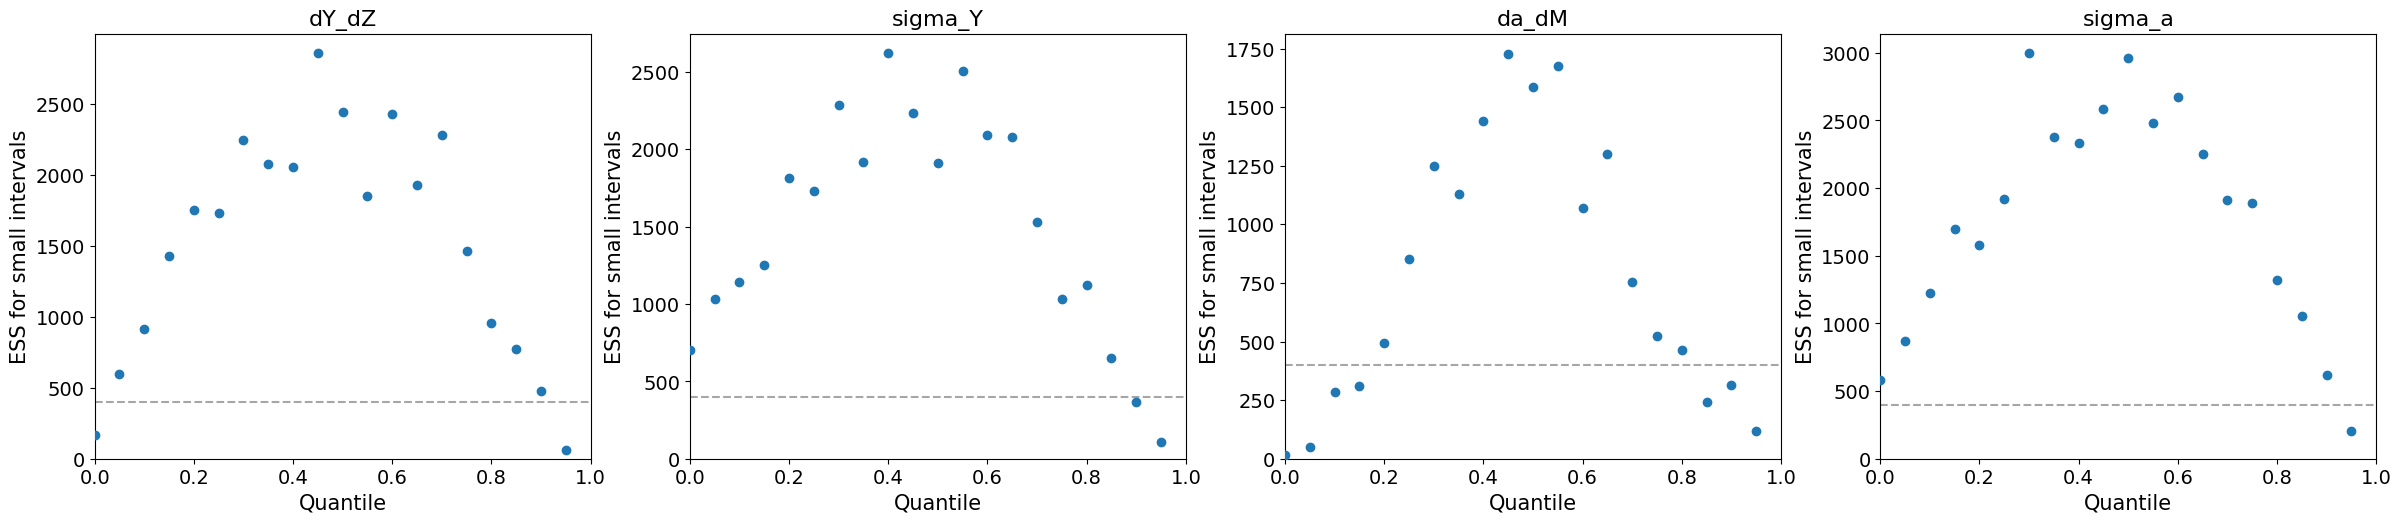

In [48]:
az.plot_ess(data, var_names=hyperparam_names);

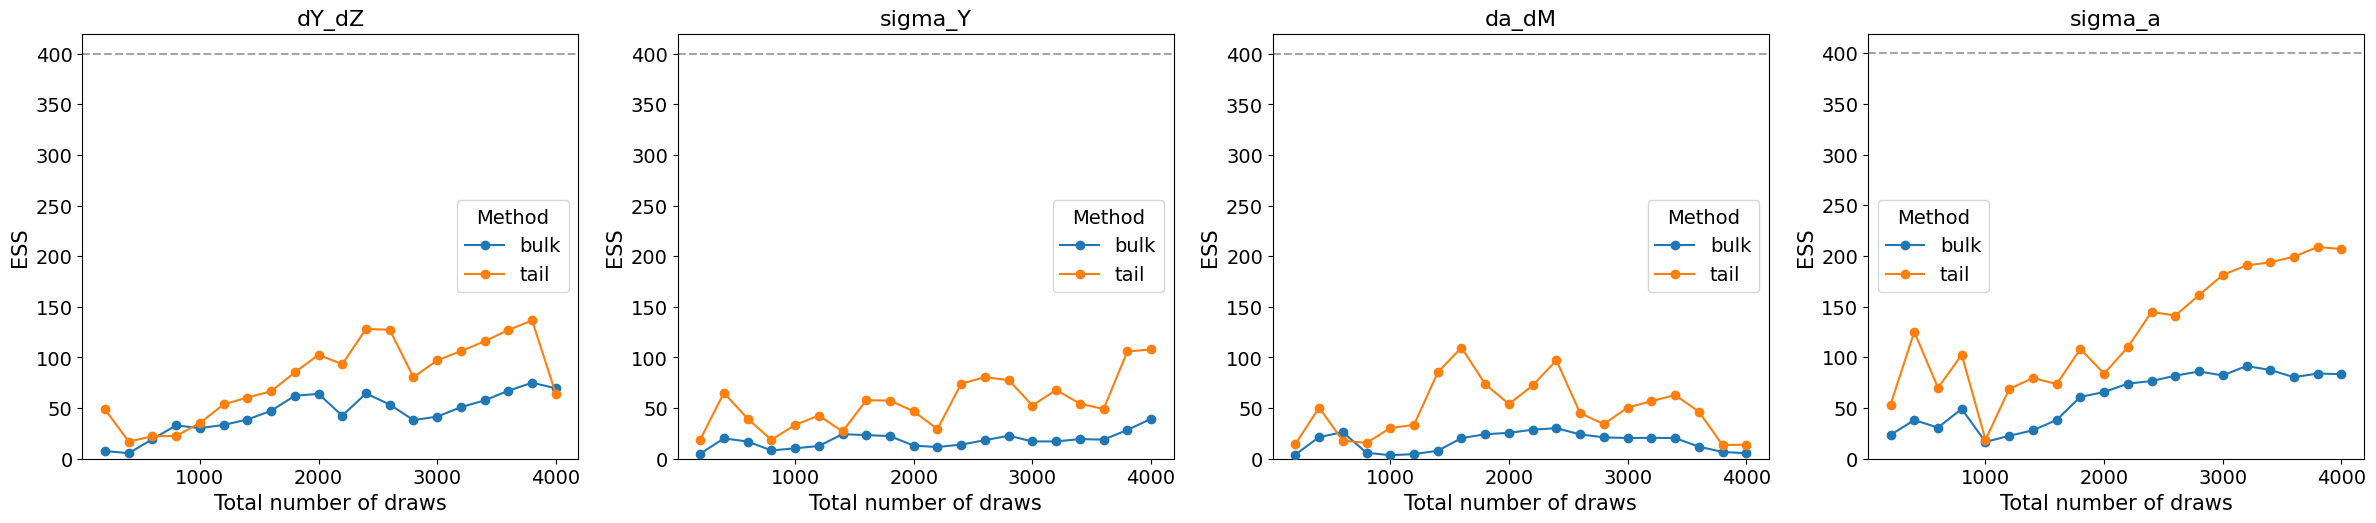

In [49]:
az.plot_ess(data, kind="evolution", var_names=hyperparam_names);

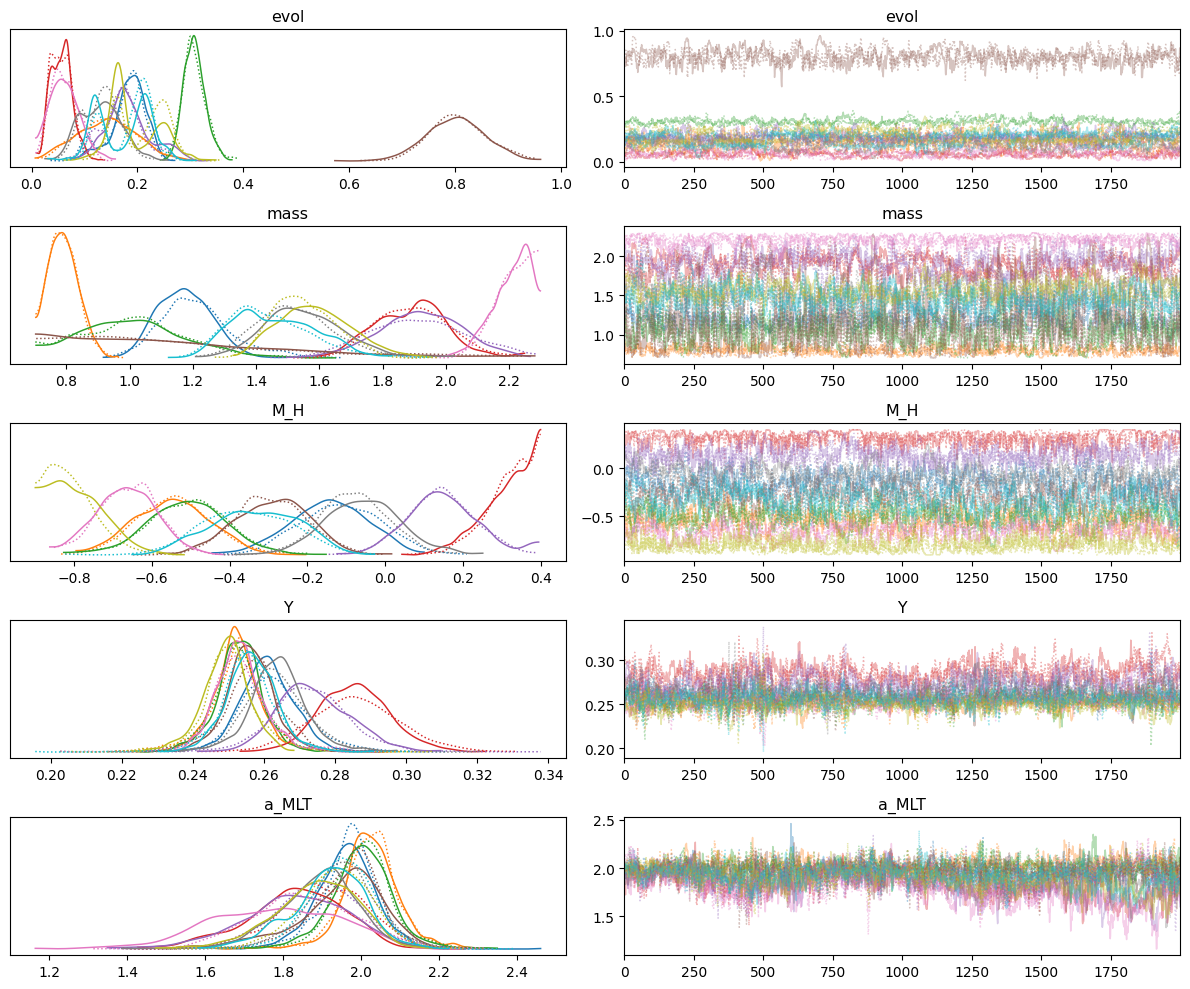

In [50]:
var_names = ["evol", "mass", "M_H", "Y", "a_MLT"]
az.plot_trace(data, var_names=var_names, coords=dict(star=range(10)))
plt.tight_layout()

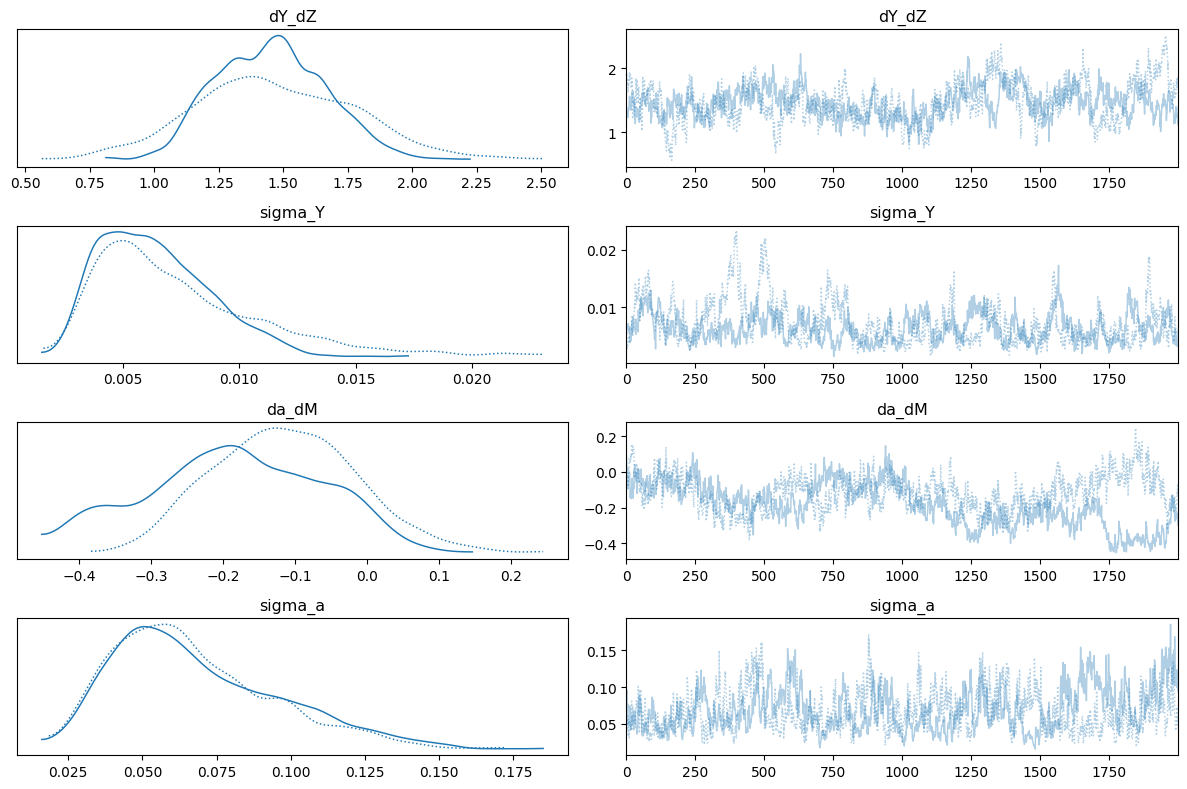

In [51]:
az.plot_trace(data, var_names=hyperparam_names)
plt.tight_layout()

## Posterior Predictive

Let's check the joint posterior distributions and compare with the truth values.

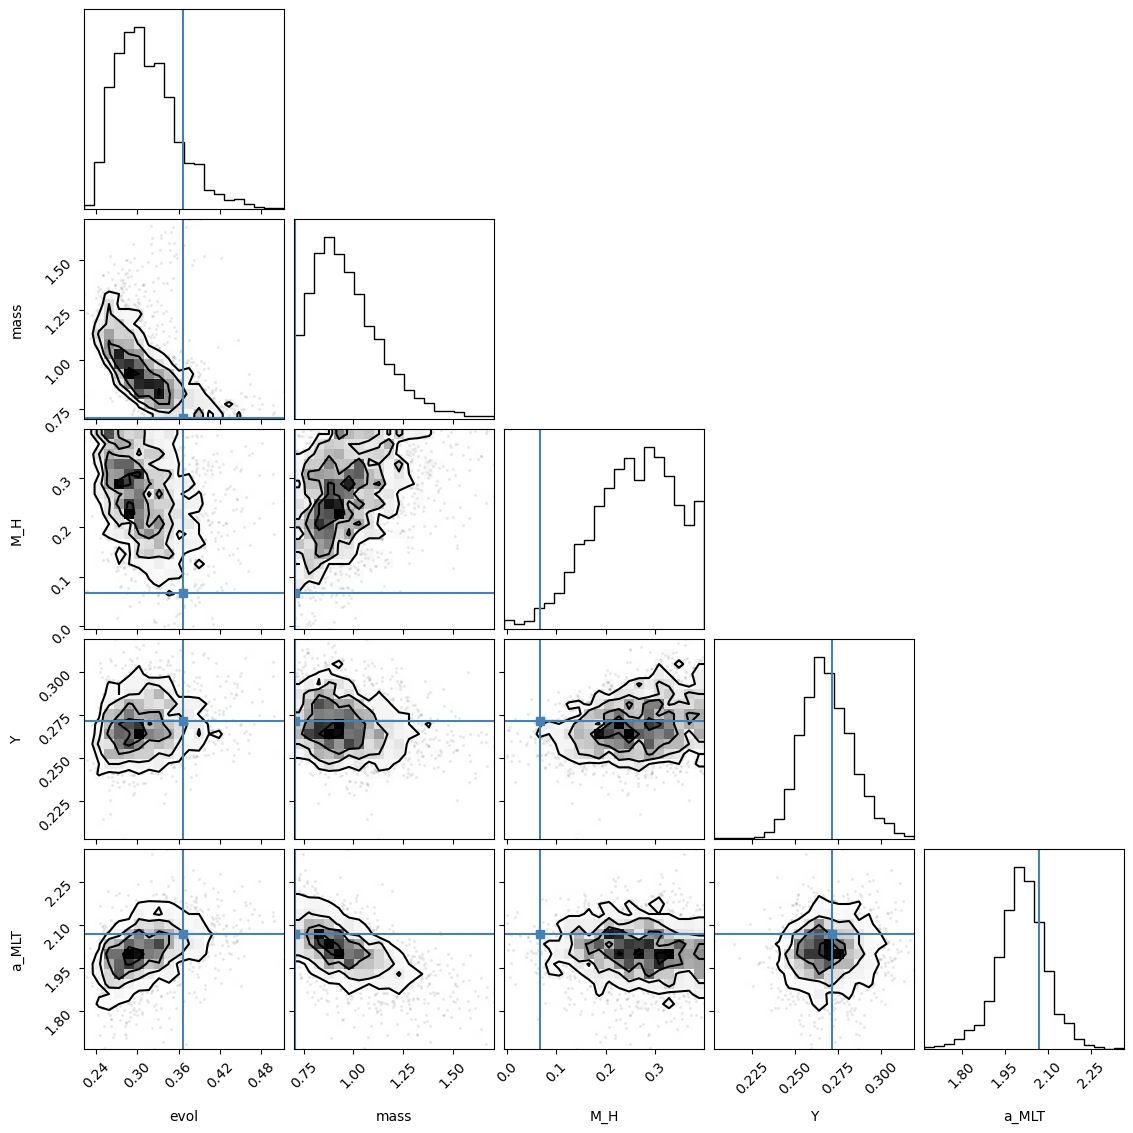

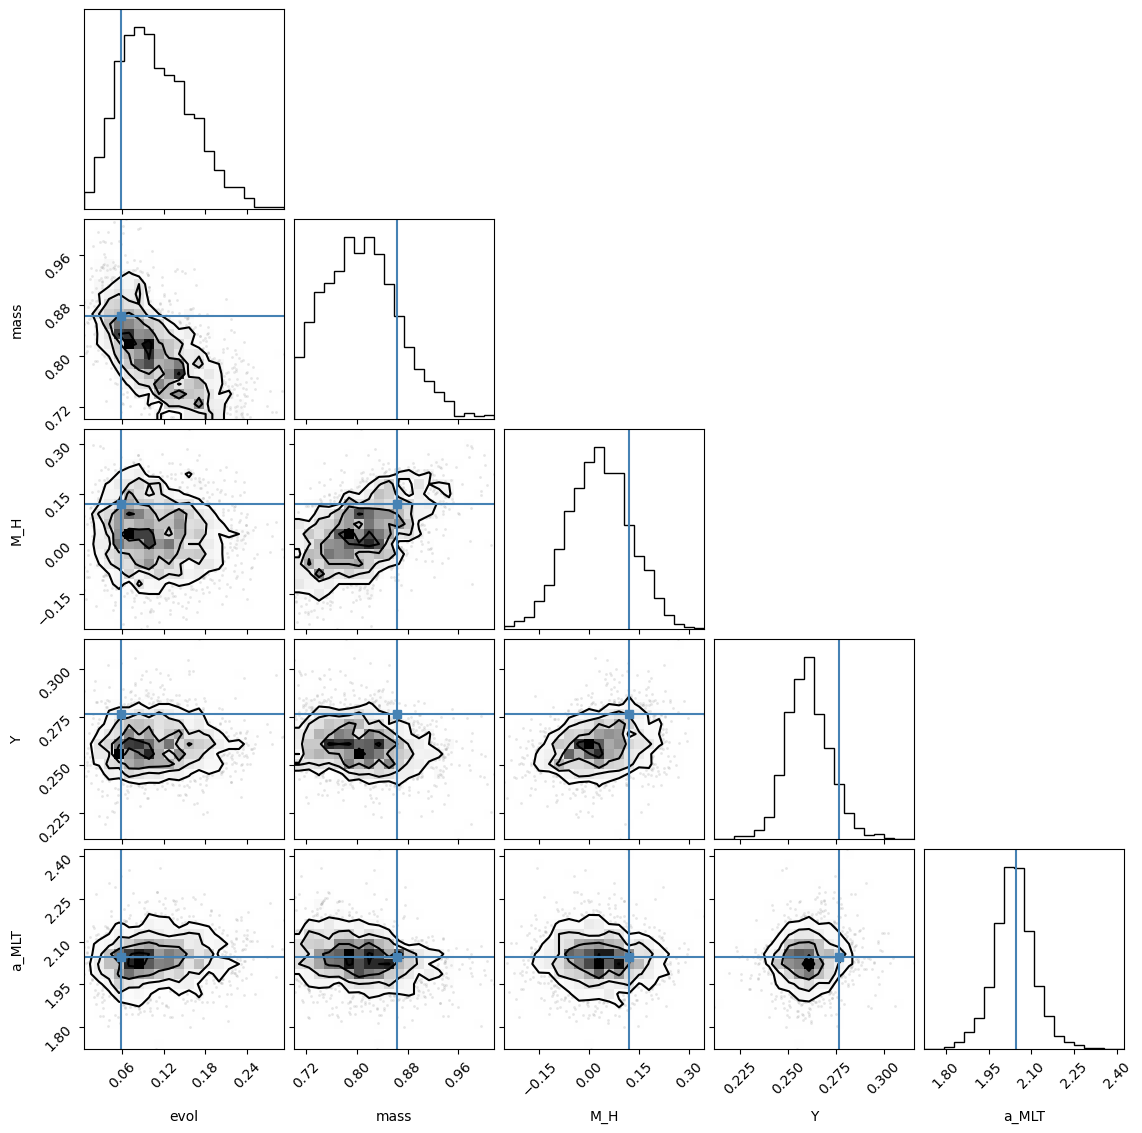

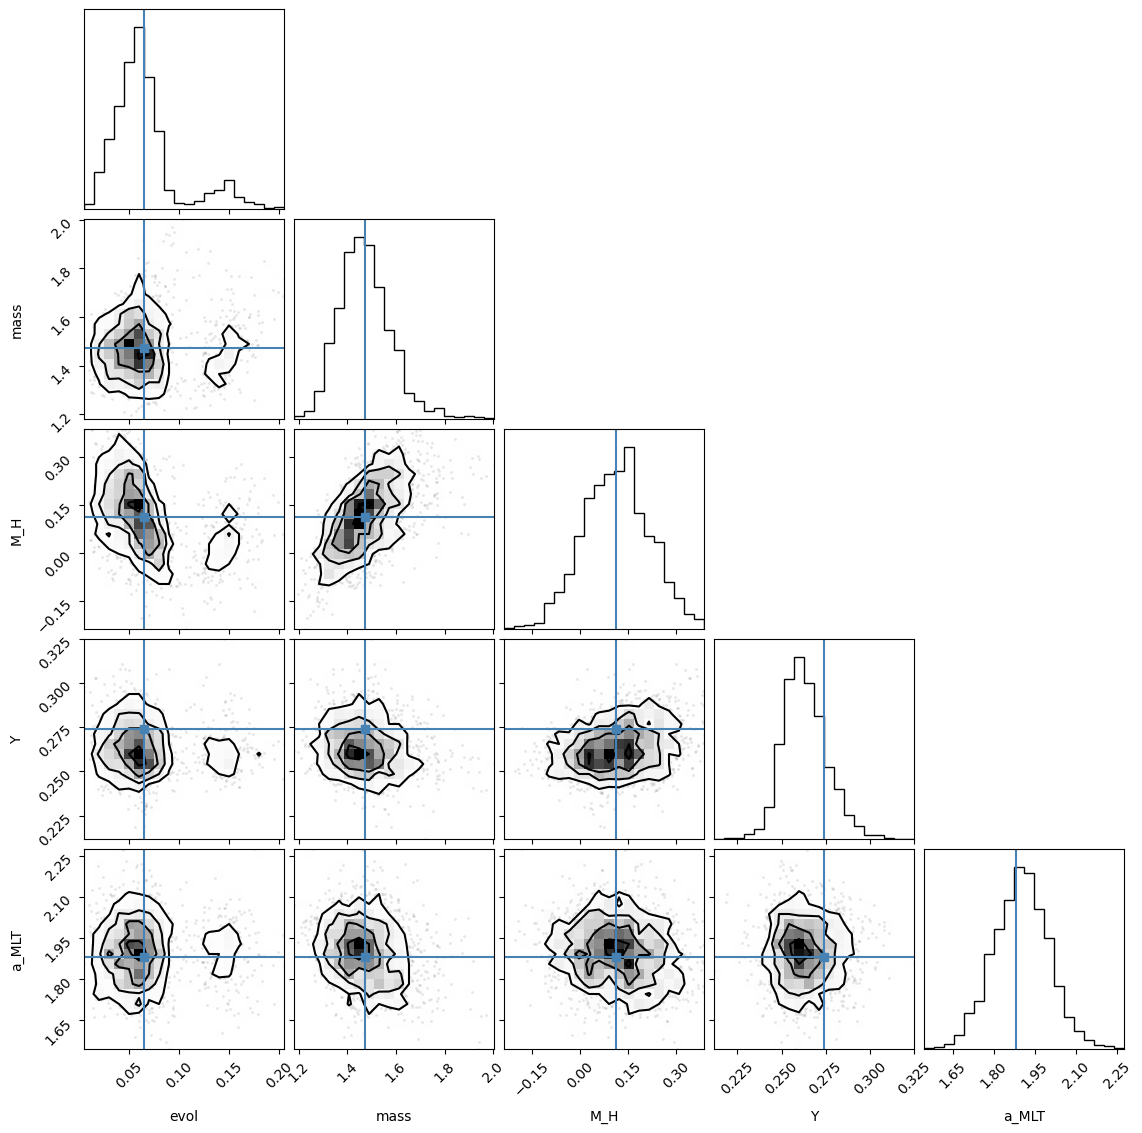

In [18]:
var_names = ["evol", "mass", "M_H", "Y", "a_MLT"]
for star in range(3):
    coords_ = {"star": star}
    truths_ = {key: truths[key][star] for key in var_names}
    fig = corner(data, group="posterior", var_names=var_names, truths=truths_, coords=coords_)

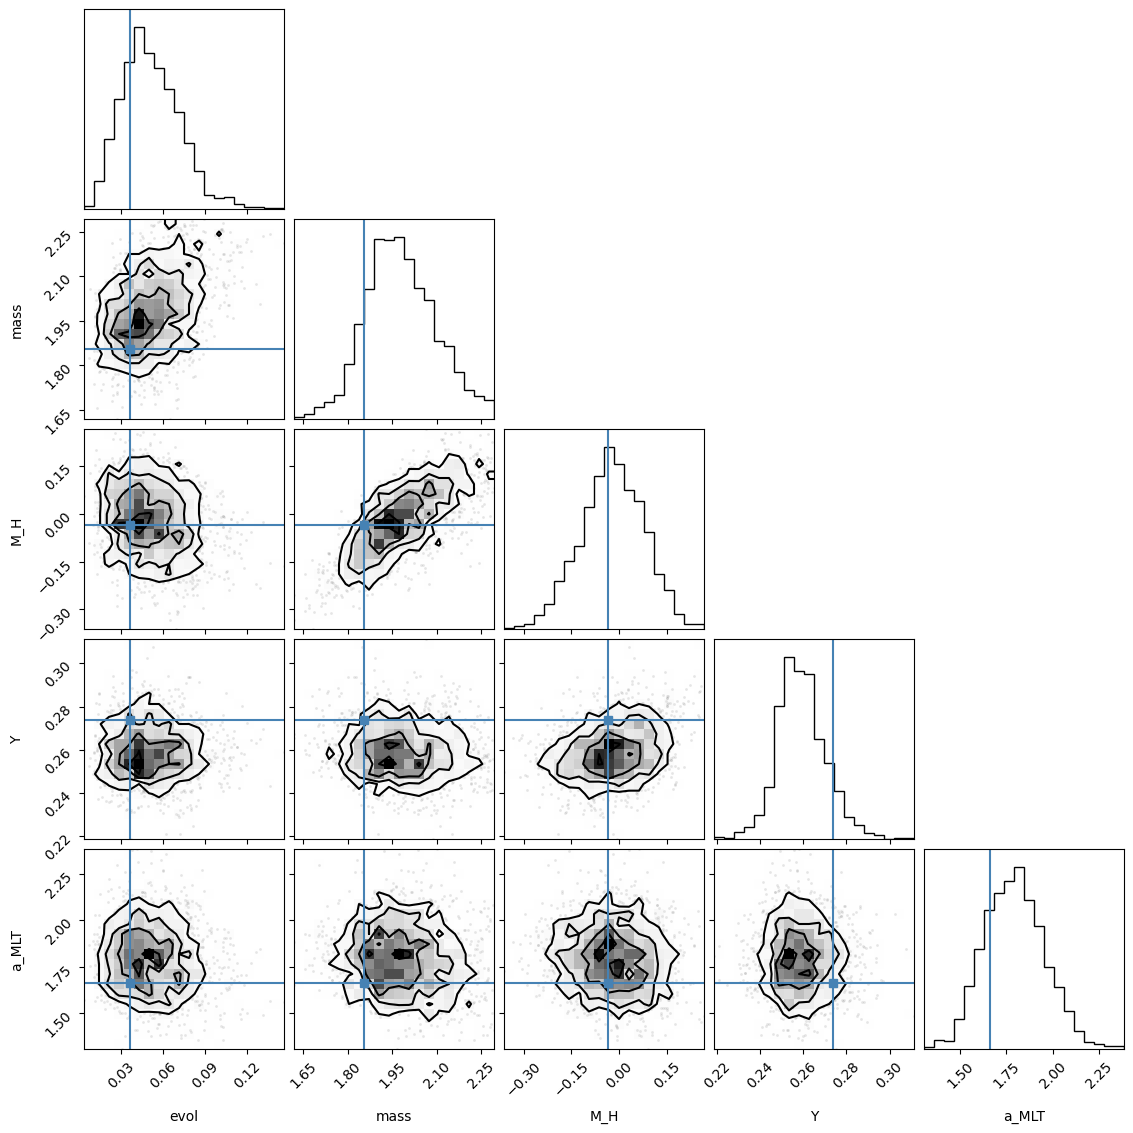

In [19]:
var_names = ["evol", "mass", "M_H", "Y", "a_MLT"]
star = 11
coords_ = {"star": star}
truths_ = {key: truths[key][star] for key in var_names}
fig = corner(data, group="posterior", var_names=var_names, truths=truths_, coords=coords_)

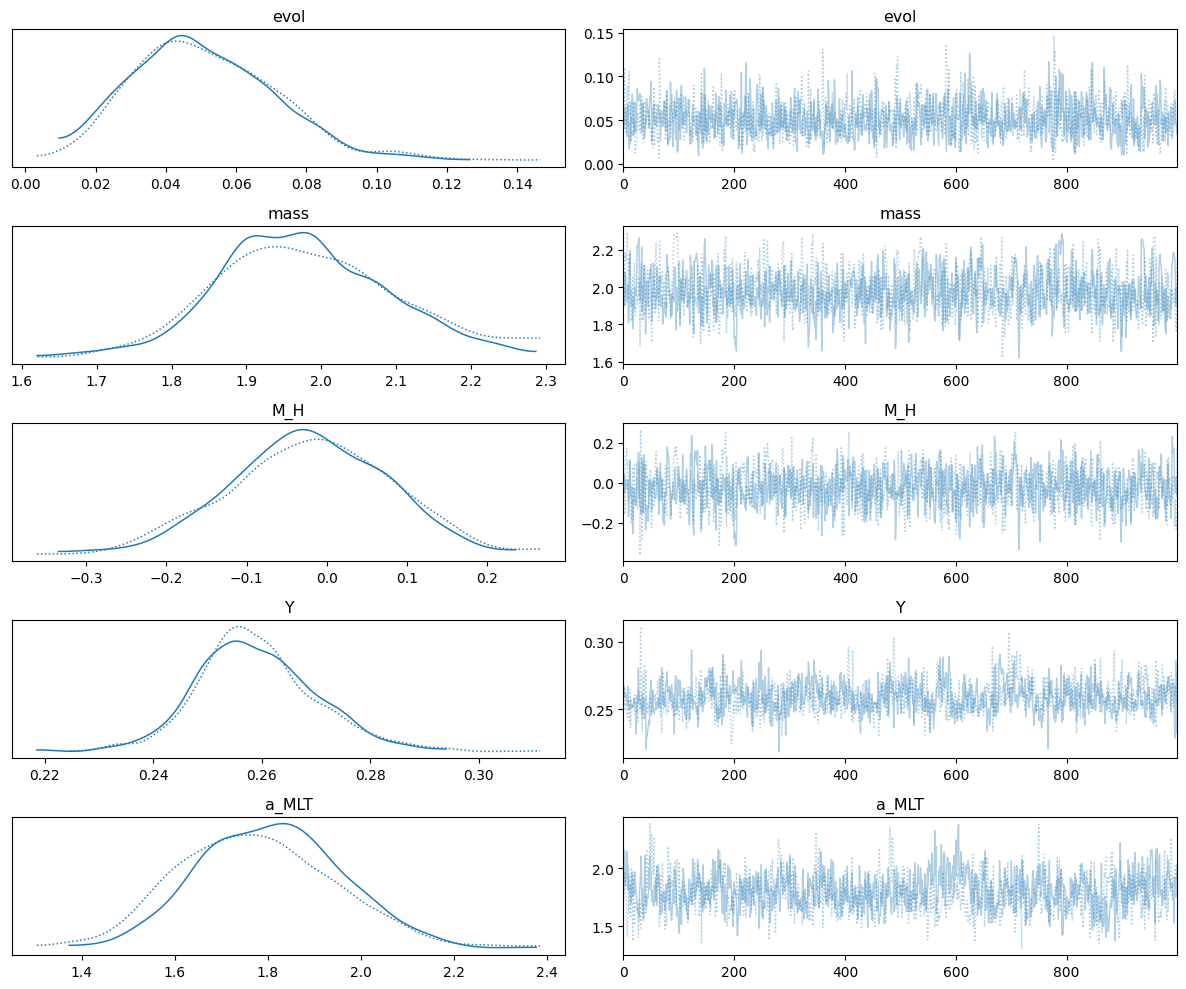

In [20]:
az.plot_trace(data, var_names=var_names, coords=coords_)
plt.tight_layout()

What do we predict for some deterministics?

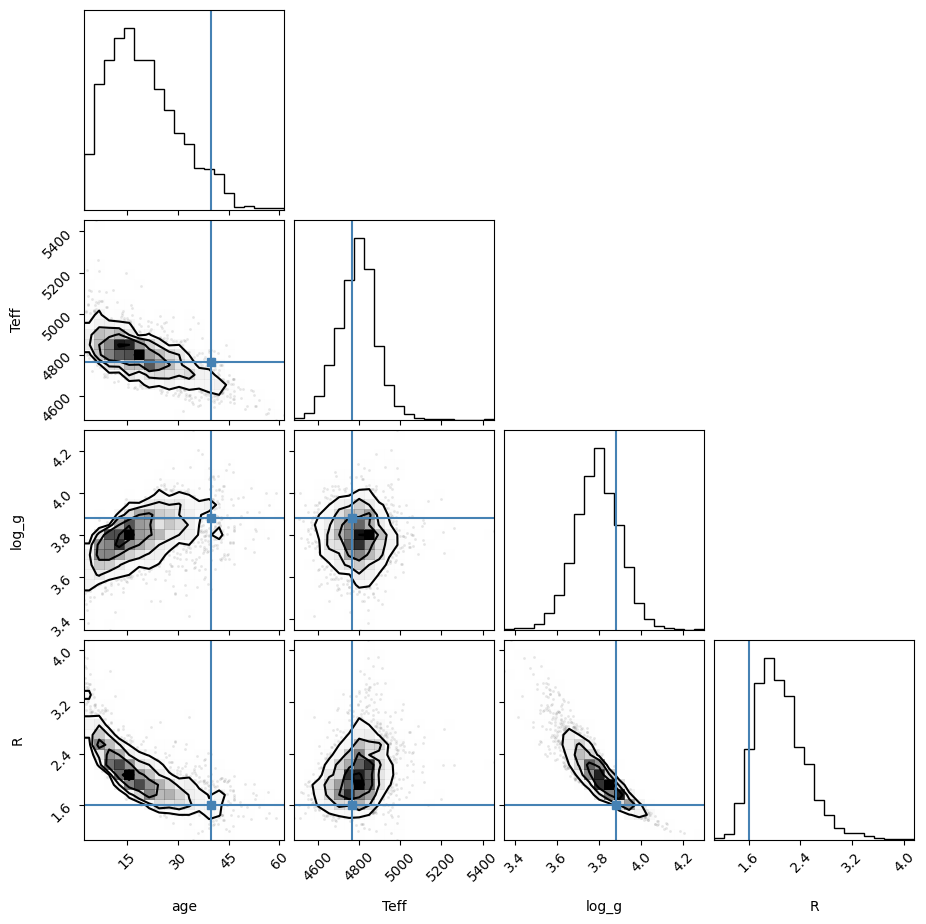

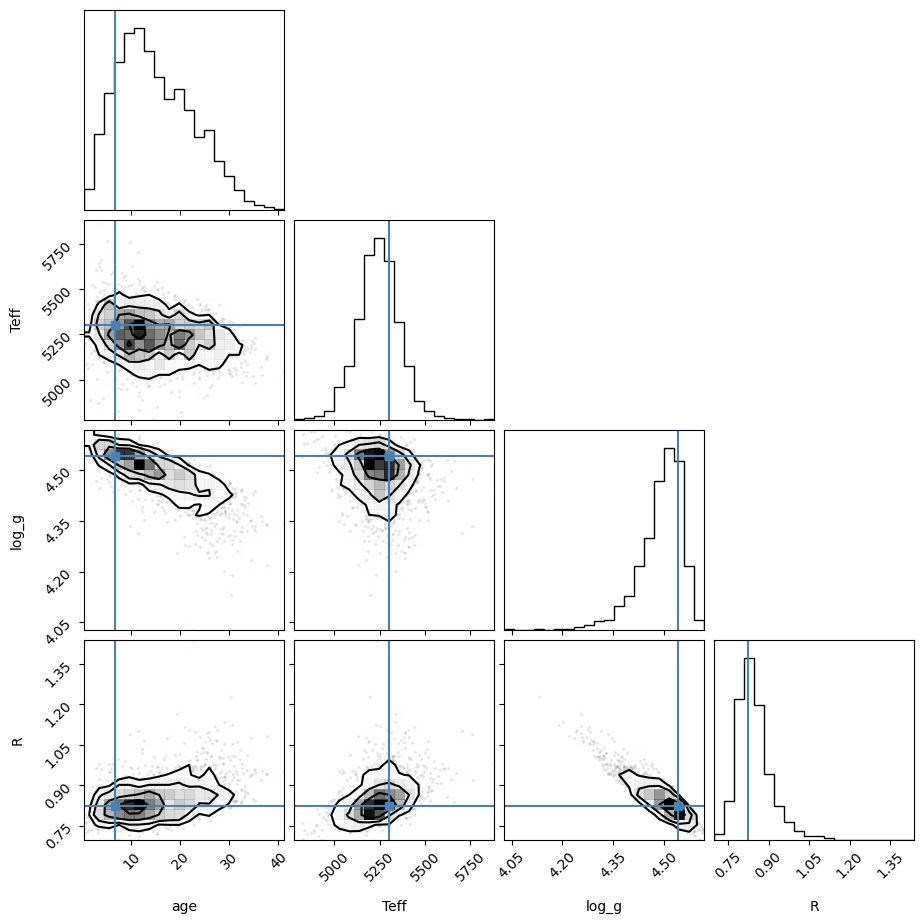

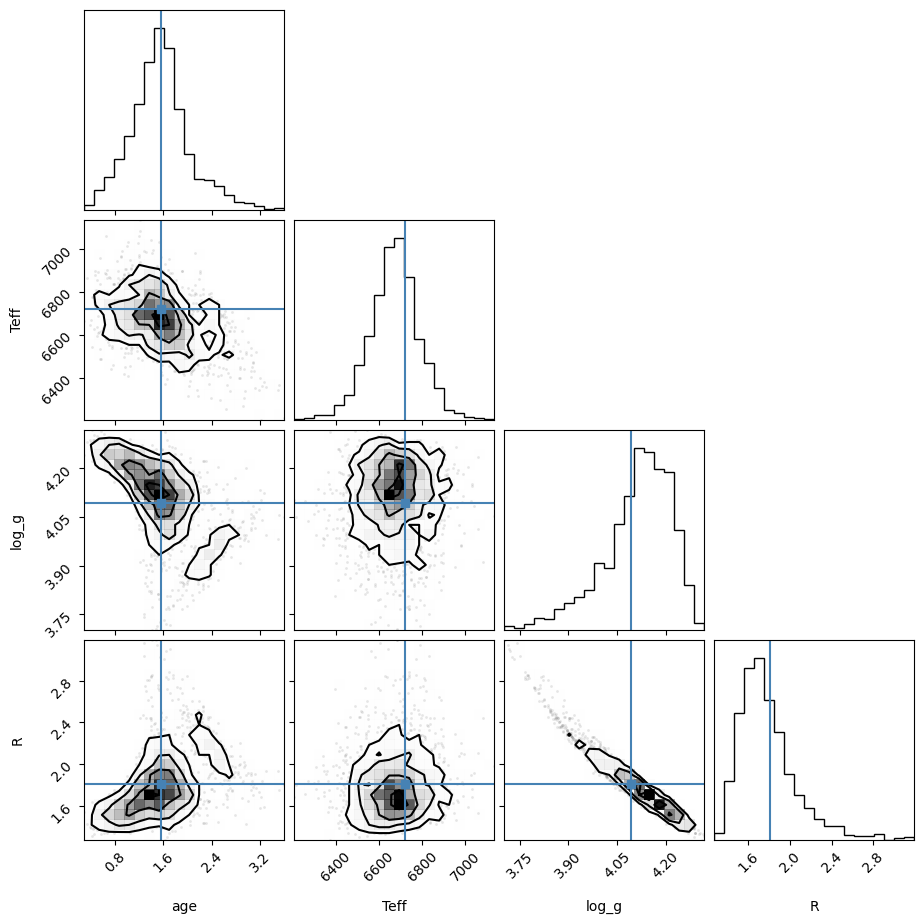

In [21]:
var_names = ["age", "Teff", "log_g", "R"]
for star in range(3):
    coords_ = {"star": star}
    truths_ = {key: truths[key][star] for key in var_names}
    fig = corner(data, group="posterior", var_names=var_names, truths=truths_, coords=coords_)

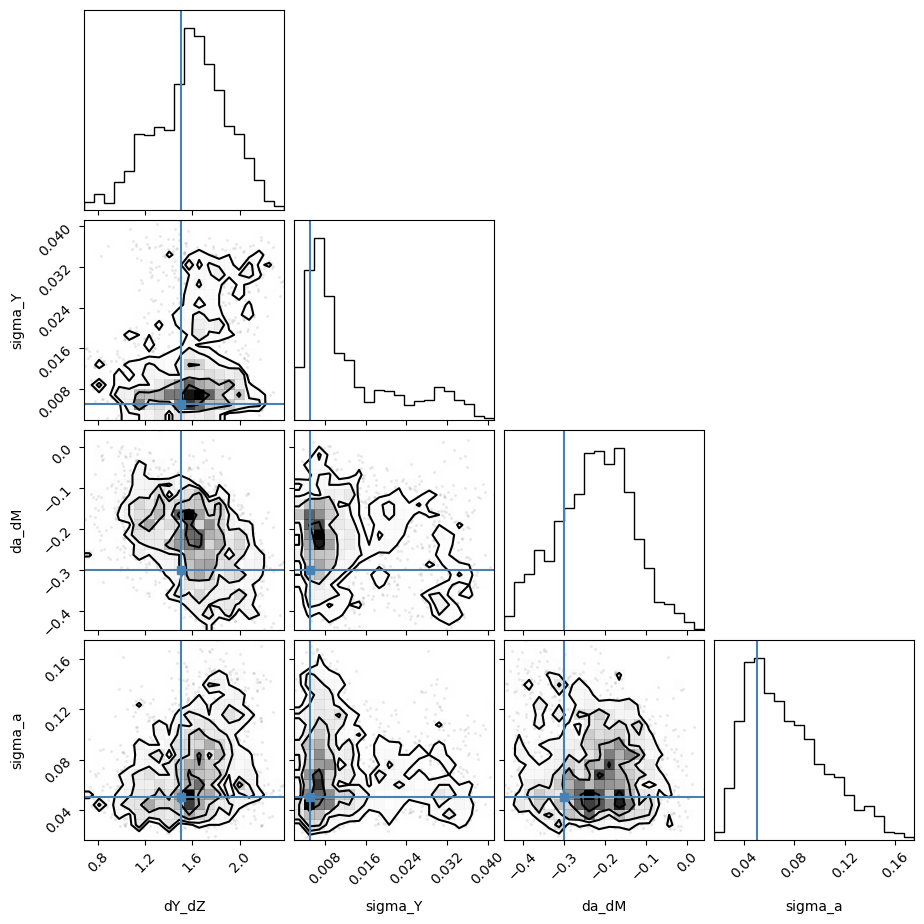

In [34]:
fig = corner(data, group="posterior", var_names=hyperparam_names, truths=truths)

Let's look at the fractional error between each posterior sample and the truth. This gives us an idea of the precision and accuracy of our results. Don't expect anything impressive, we are marginalising over `Y` and `a_MLT` after all.

In [23]:
error = truths - data.posterior
az.summary(error)

mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  \
M_H[0]   -0.191  0.084  -0.333   -0.053      0.002    0.002     927.0   
M_H[1]    0.091  0.092  -0.086    0.259      0.003    0.002    1053.0   
M_H[2]   -0.002  0.102  -0.203    0.178      0.005    0.004     347.0   
M_H[3]   -0.154  0.093  -0.321    0.024      0.002    0.002    1390.0   
M_H[4]    0.003  0.097  -0.182    0.180      0.002    0.002    1682.0   
...         ...    ...     ...      ...        ...      ...       ...   
mass[97] -0.030  0.055  -0.123    0.078      0.002    0.001     715.0   
mass[98]  0.164  0.121  -0.013    0.380      0.005    0.003     690.0   
mass[99] -0.135  0.159  -0.421    0.161      0.010    0.007     254.0   
sigma_Y  -0.002  0.004  -0.009    0.003      0.000    0.000     499.0   
sigma_a  -0.014  0.028  -0.063    0.026      0.001    0.001     867.0   

          ess_tail  r_hat  
M_H[0]       595.0   1.00  
M_H[1]      1160.0   1.00  
M_H[2]       490.0   1.01  
M_H[3]      1264.0   1.00  
M_H[4]       849.0   1.00  
...            ...    ...  
mass[97]     755.0   1.00  
mass[98]     791.0   1.00  
mass[99]     479.0   1.00  
sigma_Y      571.0   1.00  
sigma_a      994.0   1.00  

[1804 rows x 9 columns]

In [24]:
fractional_error = (truths - data.posterior) / truths
az.summary(fractional_error)

mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  \
M_H[0]   -2.883  1.260  -5.029   -0.795      0.037    0.031     927.0   
M_H[1]    0.755  0.765  -0.710    2.149      0.024    0.017    1053.0   
M_H[2]   -0.020  0.915  -1.821    1.601      0.049    0.034     347.0   
M_H[3]    0.255  0.155  -0.039    0.532      0.004    0.003    1390.0   
M_H[4]   -0.005  0.152  -0.281    0.285      0.004    0.004    1682.0   
...         ...    ...     ...      ...        ...      ...       ...   
mass[97] -0.038  0.068  -0.152    0.096      0.002    0.002     715.0   
mass[98]  0.072  0.053  -0.006    0.166      0.002    0.001     690.0   
mass[99] -0.084  0.099  -0.262    0.100      0.006    0.004     254.0   
sigma_Y  -0.471  0.720  -1.863    0.543      0.035    0.025     499.0   
sigma_a  -0.282  0.552  -1.260    0.519      0.020    0.015     867.0   

          ess_tail  r_hat  
M_H[0]       595.0   1.00  
M_H[1]      1160.0   1.00  
M_H[2]       490.0   1.01  
M_H[3]      1264.0   1.00  
M_H[4]       849.0   1.00  
...            ...    ...  
mass[97]     755.0   1.00  
mass[98]     791.0   1.00  
mass[99]     479.0   1.00  
sigma_Y      571.0   1.00  
sigma_a      994.0   1.00  

[1804 rows x 9 columns]

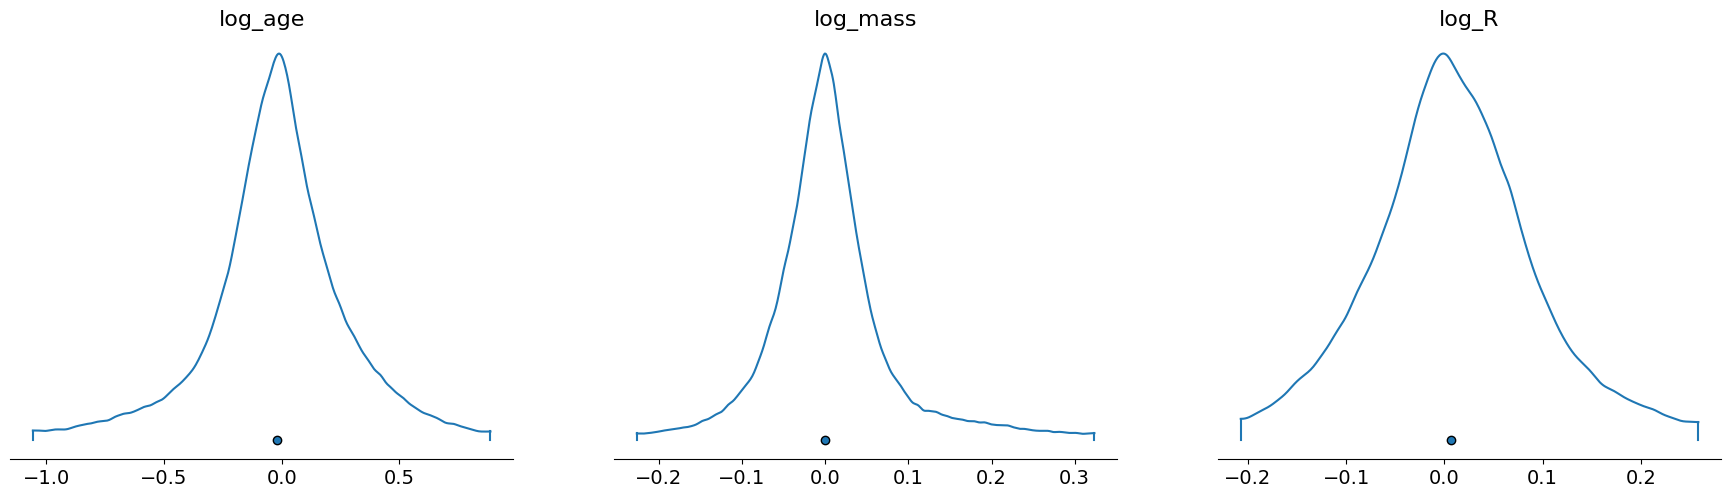

In [25]:
az.plot_density(error, var_names=["log_age", "log_mass", "log_R"], combine_dims={"star"}, 
                point_estimate="median", hdi_prob=0.98);

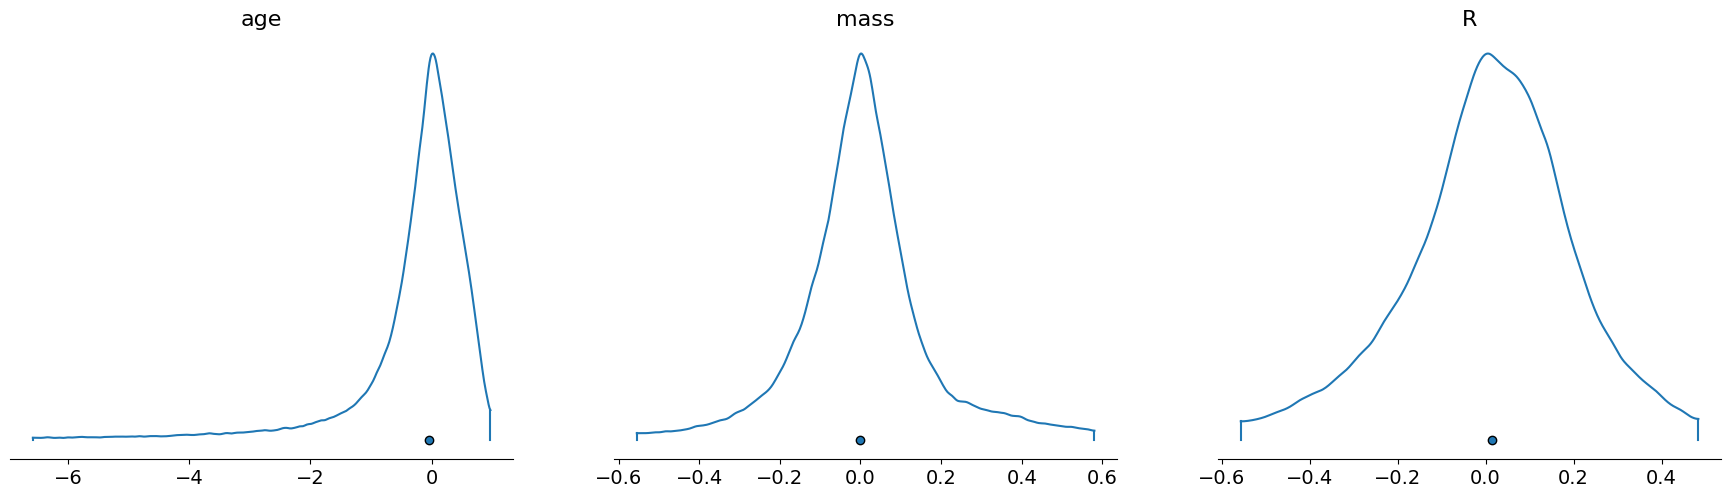

In [26]:
az.plot_density(fractional_error, var_names=["age", "mass", "R"], combine_dims={"star"}, 
                point_estimate="median", hdi_prob=0.98);

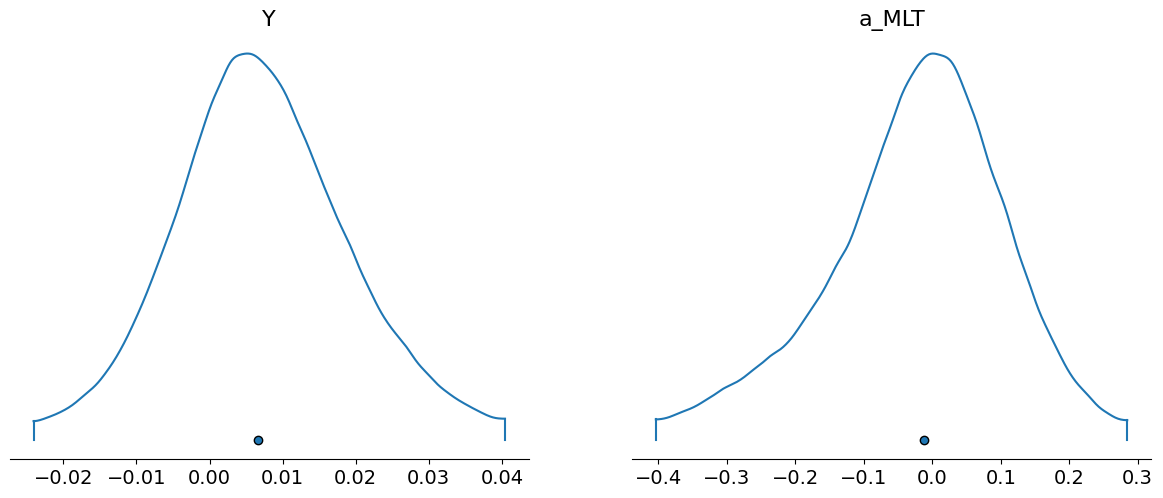

In [27]:
az.plot_density(error, var_names=["Y", "a_MLT"], combine_dims={"star"}, 
                point_estimate="median", hdi_prob=0.98);

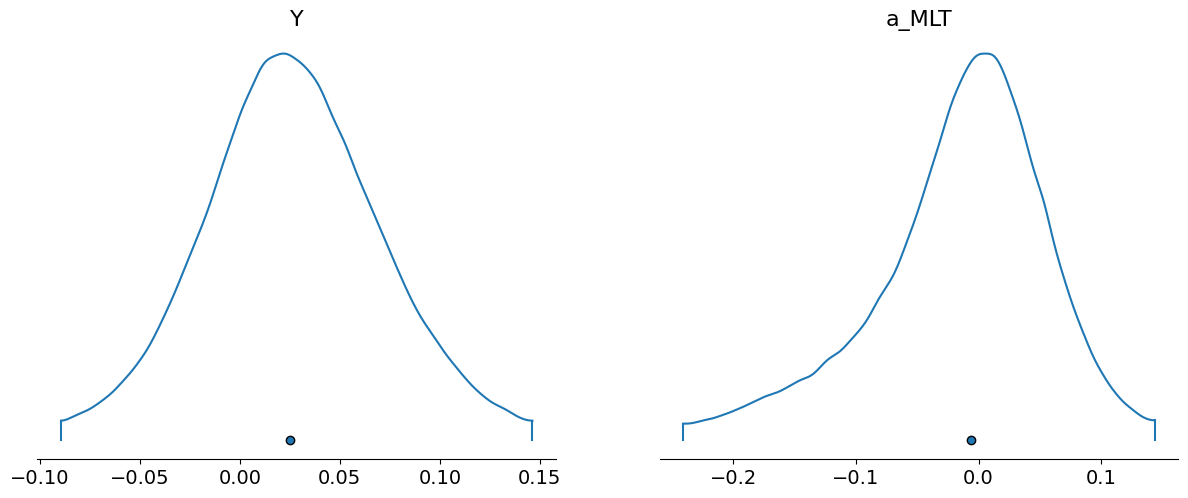

In [28]:
az.plot_density(fractional_error, var_names=["Y", "a_MLT"], combine_dims={"star"}, 
                point_estimate="median", hdi_prob=0.98);